# 02: Ames Preprocessing

Data taken from [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) by Dean De Cock (hereinafter referred to as 'the author').

In [131]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  
import seaborn as sns 
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, HuberRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

## import and explore initial correlations

In [100]:
train = pd.read_csv('./data/train_eda.csv')
train.shape

(2051, 81)

Per suggestion of the author, it's recommended to removedata points above 4000 square feet (`gr_liv_area`).

In [101]:
train = train[train['gr_liv_area'] <= 4000]
train.shape

(2049, 81)

In [102]:
train.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,age,remod_age
0,MSSC60,RL,0.0,13517,2,0,3,Lvl,4,CulDSac,...,0,none,none,0,mar,ten,WD,130500,34,5
1,MSSC60,RL,43.0,11492,2,0,3,Lvl,4,CulDSac,...,0,none,none,0,apr,nine,WD,220000,13,12
2,MSSC20,RL,68.0,7922,2,0,4,Lvl,4,Inside,...,0,none,none,0,jan,ten,WD,109000,57,3
3,MSSC60,RL,73.0,9802,2,0,4,Lvl,4,Inside,...,0,none,none,0,apr,ten,WD,174000,4,3
4,MSSC50,RL,82.0,14235,2,0,3,Lvl,4,Inside,...,0,none,none,0,mar,ten,WD,138500,110,17


In [103]:
train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
overall_qual,0.803462
gr_liv_area,0.719463
exter_qual,0.715048
kitchen_qual,0.694295
total_bsmt_sf,0.665116
garage_area,0.655097
1st_flr_sf,0.648252
garage_cars,0.648227
bsmt_qual,0.613236


In [143]:
categorical = train.select_dtypes(include=['O']).columns.values
numerical = [c for c in train.select_dtypes(exclude=['O']).columns if 'price' not in c]

print(len(categorical))
print(categorical)
print()
print(len(numerical))
print(numerical)

26
['ms_subclass' 'ms_zoning' 'land_contour' 'lot_config' 'neighborhood'
 'condition_1' 'condition_2' 'bldg_type' 'house_style' 'roof_style'
 'roof_matl' 'exterior_1st' 'exterior_2nd' 'mas_vnr_type' 'foundation'
 'bsmt_exposure' 'bsmtfin_type_1' 'bsmtfin_type_2' 'heating' 'electrical'
 'garage_type' 'fence' 'misc_feature' 'mo_sold' 'yr_sold' 'sale_type']

54
['lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'utilities', 'land_slope', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating_qc', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_co

In [ ]:
# a lot is modeled from the following:
# https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6

class AmesTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.at = None

    def fit(self, X, y=None):
        # assumes X is a DataFrame
        self._columns = X.columns.values

        # splits data into numeric and categorical
        self._num_cols = X.select_dtypes(exclude=['O']).columns.values
        self._cat_cols = X.select_dtypes(include=['O']).columns.values

        self.at = RobustScaler().fit(X[self._num_cols])
        self.at = OneHotEncoder
        return self

    def transform(self, X, y=None):
        # check that DataFrame has same column names
        if len(self._columns) != len(X.columns):
            raise ValueError('DataFrame has different number of columns than fit DataFrame')
        elif set(self._columns) != set(X.columns):
            raise ValueError('DataFrame has different columns than fit DataFrame')

        X_num = X[self._num_cols]
        std = X_num.std()
        X_num = (X_num - X_num.mean()) / std
        zero_std = np.where(std==0)[0]

        if len(zero_std) > 0:
            X_num.iloc[:, zero_std] = 0
        X_num = X_num.values

        X_cat = X[self._cat_cols]

        

In [106]:
features = train.drop(columns='saleprice')
target = train['saleprice']

In [107]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=111)

In [108]:
def adjusted_r2(r2, obs, feats):
    
    # adjust r2 value based on number of observations and number of features
    adjusted = 1 - (1 - r2) * (obs - 1) / (obs - feats - 1)
    
    return adjusted

In [109]:
def regression_stats(model, x, y, random_state=111):

    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state)

    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)

    adj = adjusted_r2(model.score(x_test, y_test), x_test.shape[0], x_test.shape[1])

    print(f'adjusted r-squared: {adj}')
    print(f'rmse: {mean_squared_error(y_test, y_hat) ** 0.5}')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat,
        y = y_test - y_hat,
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat.min(), xmax = y_hat.max(), color = "red")
    plt.show()

    return model

adjusted r-squared: 0.6704520210951579
rmse: 46456.689670947235


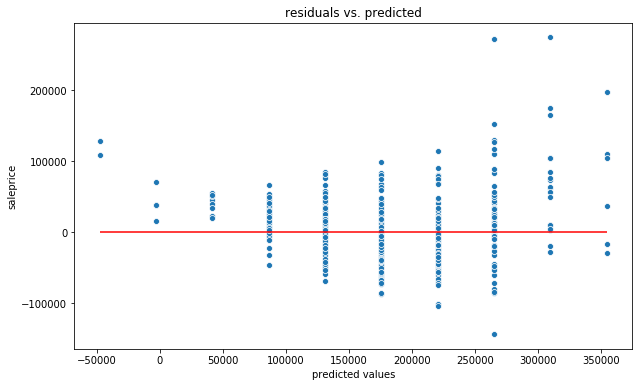

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [110]:
regression_stats(LinearRegression(), features[['overall_qual']], target)

adjusted r-squared: 0.4891121422855417
rmse: 57843.12189950729


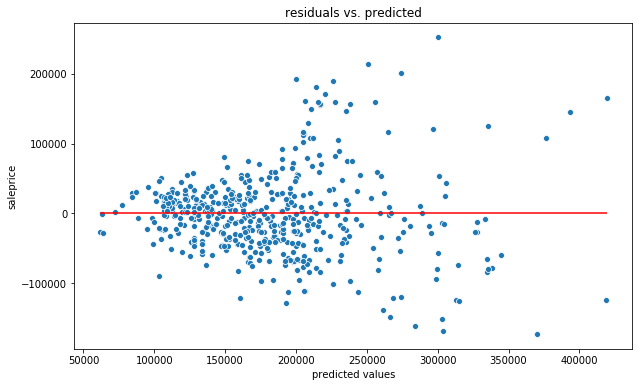

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
regression_stats(LinearRegression(), features[['gr_liv_area']], target)

Our residuals do not appear to be:
- random
- evenly variant as a function of our predicted value
- insensitive to outliers

Therefore, we should attempt:
- using better (or more) features
- feature engineering
- further preprocessing of our data

## multiple linear regression

adjusted r-squared: 0.7543454997334205
rmse: 40070.608210945524


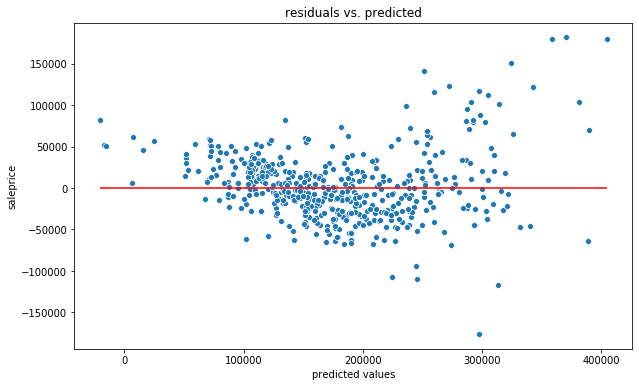

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
regression_stats(LinearRegression(), features[['gr_liv_area', 'overall_qual']], target)

adjusted r-squared: 0.7842467151206022
rmse: 37515.961677287596


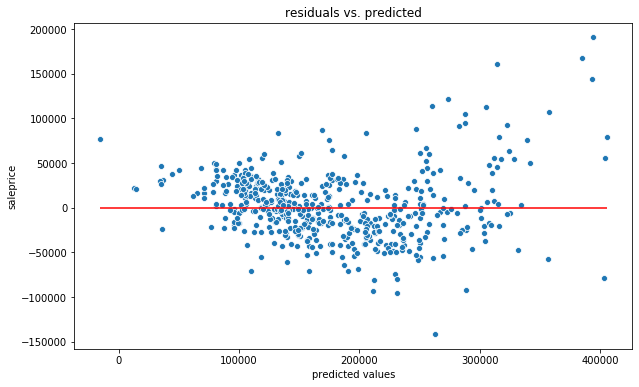

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [113]:
regression_stats(LinearRegression(), features[['gr_liv_area', 'overall_qual', 'exter_qual']], target)

Going at this one-by-one is a time-consuming and probably fruitless task. We will discuss how to 'automate' this process later. The main takeaway is that we can see that adding in more features does improve our scores, 

However, the residuals are still non-homoskedastic (from the "banana" shape). We can attempt to fix this by performing a non-linear transformation of our target `saleprice`.

In [114]:
def transformed_regression_stats(model, x, y, random_state=111):

    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state)

    tt = TransformedTargetRegressor(
        regressor = model,
        func = np.log1p,
        inverse_func = np.expm1
    )

    tt.fit(x_train, y_train)
    y_hat = tt.predict(x_test)

    adj = adjusted_r2(tt.score(x_test, y_test), x_test.shape[0], x_test.shape[1])

    print(f'adjusted r-squared: {adj}')
    print(f'rmse: {mean_squared_error(y_test, y_hat) ** 0.5}')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat,
        y = y_test - y_hat,
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat.min(), xmax = y_hat.max(), color = "red")
    plt.show()

    return model

adjusted r-squared: 0.8258478014733054
rmse: 33705.58396930731


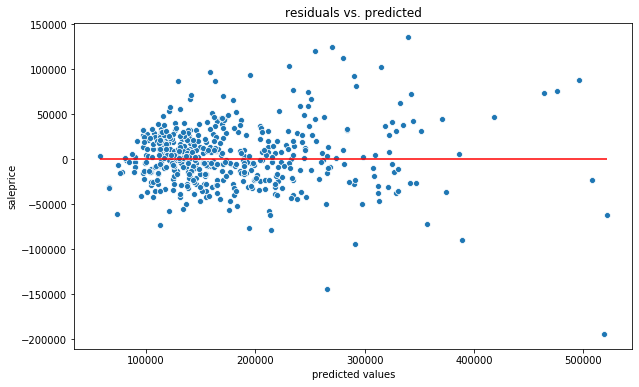

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
transformed_regression_stats(LinearRegression(), features[['gr_liv_area', 'overall_qual', 'exter_qual']], target)

We see improvement in the r-squared value, and the residuals have a more even variance.

adjusted r-squared: 0.8258261045680401
rmse: 33707.68352387014


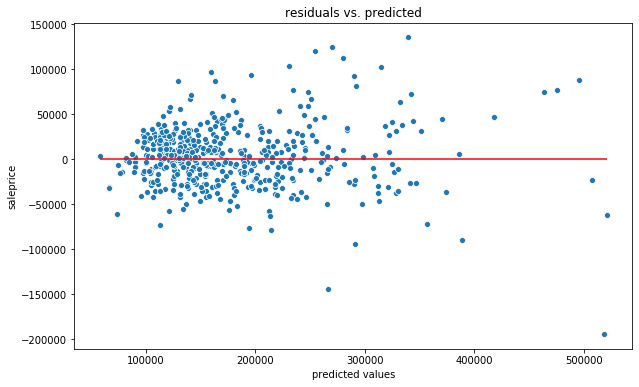

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [158]:
transformed_regression_stats(Ridge(), features[['gr_liv_area', 'overall_qual', 'exter_qual']], target)

## Further Transformations: Scaling, Polynomial Features, and One-Hot Encoding

In [119]:
features.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,age,remod_age
0,MSSC60,RL,0.0,13517,2,0,3,Lvl,4,CulDSac,...,0,0,none,none,0,mar,ten,WD,34,5
1,MSSC60,RL,43.0,11492,2,0,3,Lvl,4,CulDSac,...,0,0,none,none,0,apr,nine,WD,13,12
2,MSSC20,RL,68.0,7922,2,0,4,Lvl,4,Inside,...,0,0,none,none,0,jan,ten,WD,57,3
3,MSSC60,RL,73.0,9802,2,0,4,Lvl,4,Inside,...,0,0,none,none,0,apr,ten,WD,4,3
4,MSSC50,RL,82.0,14235,2,0,3,Lvl,4,Inside,...,0,0,none,none,0,mar,ten,WD,110,17


In [139]:
features.isna().sum().sum()

0

In [182]:
def transformed_feature_regression_stats(model, x, y, random_state=111):

    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state)

    num_trans = Pipeline([
        ('poly', PolynomialFeatures(degree=2,
                                    include_bias=False)),
        ('robust', RobustScaler())
    ])

    cat_trans = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore',
                                 sparse=False))
    ])

    preprocess = ColumnTransformer(transformers=[
        ('num', num_trans, x.select_dtypes(exclude=['O']).columns.values),
        ('cat', cat_trans, x.select_dtypes(include=['O']).columns.values)
    ])

    z_train = preprocess.fit_transform(x_train)
    z_test = preprocess.transform(x_test)

    tt = TransformedTargetRegressor(
        regressor = model,
        func = np.log1p,
        inverse_func = np.expm1
    )

    tt.fit(z_train, y_train)
    y_hat = tt.predict(z_test)

    # adj = adjusted_r2(tt.score(z_test, y_test), z_test.shape[0], z_test.shape[1])

    print(f'adjusted r-squared: {r2_score(y_test, y_hat)}')
    print(f'rmse: {mean_squared_error(y_test, y_hat) ** 0.5}')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat,
        y = y_test - y_hat,
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat.min(), xmax = y_hat.max(), color = "red")
    plt.show()

    return model

adjusted r-squared: 0.8904772260025234
rmse: 26808.078225909838


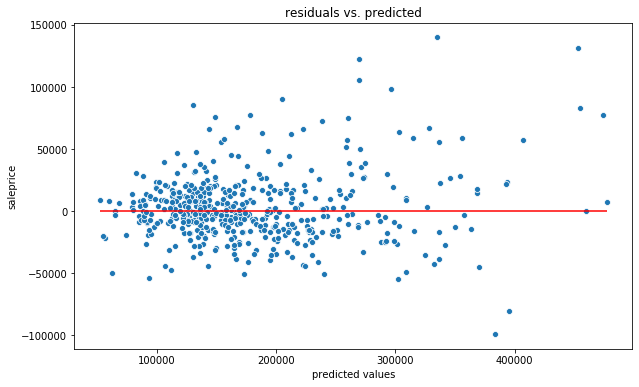

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [183]:
transformed_feature_regression_stats(LinearRegression(), 
    features[['neighborhood', 
              'gr_liv_area', 
              'overall_qual', 
              'exter_qual', 
              'age',
              'ms_subclass']], 
    target)

adjusted r-squared: 0.9107396393690411
rmse: 24201.52780182856


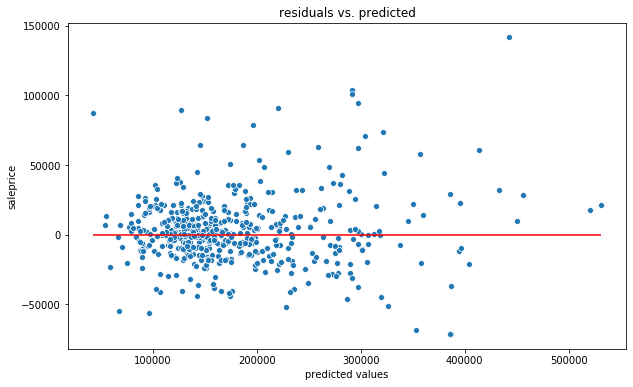

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [184]:
transformed_feature_regression_stats(Ridge(), 
    features[['neighborhood', 
              '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
              'overall_qual', 
              'exter_qual', 
              'age',
              'ms_subclass',
              'kitchen_qual',
              'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf']], 
    target)

In [167]:
transformed_feature_regression_stats(LinearRegression(), 
    features, 
    target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:179: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# https://stackoverflow.com/questions/19900202/
# https://stackoverflow.com/questions/613183/
# https://stackoverflow.com/questions/17091769/
# https://thispointer.com/pandas-how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-python/

def regression_iterator(X_t, X_h, feature_list, y_t, y_h, state):
    """
    iterates through different features and ranks them by how much they improve
    the r^2 coefficient. returns a DataFrame comparing root mean squared errors
    and adjusted r^2 values for train-test-split data.
    
    df1 : pandas.DataFrame
    
    feature_list : baseline list of features for regression 
    
    df2 : pandas.DataFrame. must be same number of rows as df1
    
    target_str : target variable
    
    state : random state for cross value scoring
    """
    
    # get RMSE and adjusted r^2
    reg1 = get_linreg_stats(X_t, X_h, feature_list, y_t, y_h, state)
    
    print(f'RMSE train: {reg1[0]}')
    print(f'RMSE hold: {reg1[1]}')
    print()
    print(f'train crossvals: {reg1[2]}')
    print(f'cv range: {reg1[4]}')
    print(f'adjusted r^2 hold: {reg1[3]}')    
    
    # container to compare RMSE and r^2 values
    iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'cv_range', 'adj r^2 hold'])
    
    # Daniel K : LA for using df.describe() to grab numeric columns
    for feature in list(X_t.columns):
        
        # we don't want to add a feature that is already in the feature list nor the target
        # and null values give errors so let's avoid those too
        if feature not in feature_list:
            
            # add a new feature to current feature list and test it out
            temp_feature_list = feature_list + [feature]
            
            reg2 = get_linreg_stats(X_t, X_h, temp_feature_list, y_t, y_h, state)
            
            # if RMSE is lower and adjusted r^2 is higher, then add it to the iterations dataframe
            if (reg2[3] > reg1[3]) and (reg2[1] < reg1[1]):
                iterations.at[feature, 'RMSE train'] = reg2[0]
                iterations.at[feature, 'RMSE hold'] = reg2[1]
                iterations.at[feature, 'crossvals'] = reg2[2]
                iterations.at[feature, 'cv_range'] = reg2[4]
                iterations.at[feature, 'adj r^2 hold'] = reg2[3]
    
    # show the 'best' additions first
    iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
    
    return iterations

In [ ]:
train['price_sf'] = train['price'] / train['sf']

In [ ]:
# subplot_boxplots(train, 'price_sf', 6)

In [61]:
preprocess.fit_transform(features_train)[:10]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [55]:
pipe = Pipeline([
    ('filter', filt_trans),
    ('lr', LinearRegression())
])

In [59]:
features_train, features_test, target_train, target_test = train_test_split(train.drop(columns='saleprice'), train['saleprice'], random_state=111)

pipe.fit(features_train, target_train)
pipe.score(features_test, target_test)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


-1.3420409193705071e+290

### convert choice categorical values to numerical scale

There are some categorical variables that provide good separation:

- exterior quality (exter_qual)
- basement height (bsmt_height)
- basement condition (bsmt_cond)
- heating quality (heating_qc)
- central air (central_air)
- kitchen quality (kitchen_qual)

Central air is Yes/No, so we can binarize that variable. All others are on a Poor-Excellent scale, which we can convert to numbers

In [ ]:
def categories_to_numbers(df):
    
    rating_dict = {
        'Ex': 5,                # excellent
        'Gd': 4,                # good
        'TA': 3,                # typical
        'Fa': 2,                # fair
        'Po': 1,                # poor
        'unknown': 0            # i am making the assumption that a missing categorical value means it's not present
    }

    rating_columns = [
        'exter_qual',
        'bsmt_height',
        'bsmt_cond',
        'heating_qc',
        'kitchen_qual',
    ]

    for column in rating_columns:
        df.replace({column: rating_dict}, inplace=True)
        df[column] = df[column].astype(float)

    train.replace({'central_air': {
        'Y': 1,
        'N': 0
    }}, inplace=True)
    train['central_air'] = train['central_air'].astype(float)
    
    new_df = df * 1                  # turns booleans into numbers
    
    return new_df

In [ ]:
train = categories_to_numbers(train)

## choose variable for exploratory SLR

In [ ]:
train.corr()[['price']].sort_values(by='price', ascending=False)

In [ ]:
slr = LinearRegression()

slr_X = train[['sf']]
slr_y = train['price']

slr.fit(slr_X, slr_y)

In [ ]:
# plt.figure(figsize=(13,8))

# sns.scatterplot(x = slr.predict(slr_X),
#                 y = slr_y - slr.predict(slr_X),
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.axhline(0, color='red')

# plt.xlabel('predicted price', fontsize = 12)
# plt.ylabel('residual', fontsize = 12)
# plt.title('predicted price vs. residual', fontsize = 14);

## assess how other variables are related to price

### price vs. overall quality (r = 0.803)

In [ ]:
# plt.figure(figsize=(13,8))

# sns.boxplot(
#     x = 'qual',
#     y = 'price',
#     data = train,
#     palette = 'GnBu'
# )

# plt.xlabel('overall quality (no units)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. overall quality', fontsize = 14);

In [ ]:
# plt.figure(figsize=(13,8))

# sns.boxplot(
#     x = 'qual',
#     y = 'price_sf',
#     data = train,
#     palette = 'GnBu'
# )

# plt.xlabel('overall quality (no units)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. overall quality', fontsize = 14);

### price vs. general living area (sqft) (r = 0.719)

In [ ]:
# plt.figure(figsize=(13, 8))

# sns.scatterplot(x = 'sf',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual'),
#                 hue = 'qual',
#                 hue_norm = (1, 9),
#                 palette = 'GnBu',
#                 alpha = 1
# )

# plt.xlim(0, 4500)
# plt.xlabel('general living area (ft^2)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. general living area', fontsize = 14);

In [ ]:
# plt.figure(figsize=(8,8))

# sns.kdeplot(train['sf'], train['price'], cmap='magma', shade=True, shade_lowest=False)

# plt.xlabel('general living area (ft^2)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. general living area', fontsize = 14);

### exterior quality (exter_qual) (r^2 = 0.716)

In [ ]:
plt.figure(figsize=(13,8))

sns.boxplot(
    x = 'exter_qual',
    y = 'price_sf',
    data = train,
    palette = ['#250351', '#5B0870', '#A51F66', '#EB6B3E']
)

plt.xlabel('exterior quality (no units)', fontsize = 12)
plt.ylabel('price per sqft (USD/ft^2)', fontsize = 12)
plt.title('price density vs. exterior quality', fontsize = 14);

In [ ]:
train['sf'].describe()

In [ ]:
train[train['exter_qual'] == 5]['price_sf'].describe()

In [ ]:
train[train['exter_qual'] == 5]['sf'].describe()

In [ ]:
train[train['exter_qual'] == 4]['price_sf'].describe()

In [ ]:
train[train['exter_qual'] == 3]['price_sf'].describe()

In [ ]:
train[train['exter_qual'] == 3]['sf'].describe()

In [ ]:
train[train['exter_qual'] == 2]['price_sf'].describe()

In [ ]:
train['sf'].describe()

In [ ]:
plt.figure(figsize=(13, 8))

sns.scatterplot(x = 'year_remod_add',
                y = 'price_sf',
                data = train.sort_values(by = 'exter_qual'),
                hue = 'exter_qual',
                palette = ['#250351', '#5B0870', '#A51F66', '#EB6B3E'],
                alpha = 1
)

plt.xlabel('year built', fontsize = 12)
plt.ylabel('price per sqft (USD/ft^2)', fontsize = 12)
plt.title('price density vs. year built', fontsize = 14);

### kitchen quality (kitchen_qual) (r^2 = 0.694)

In [ ]:
plt.figure(figsize=(13,8))

sns.boxplot(
    x = 'kitchen_qual',
    y = 'price_sf',
    data = train,
    palette = ['#011E58', '#404559', '#7B7865', '#D2BE4D'],
)

plt.xlabel('kitchen quality (no units)', fontsize = 12)
plt.ylabel('price per sqft (USD/ft^2)', fontsize = 12)
plt.title('price density vs. kitchen quality', fontsize = 14);

In [ ]:
plt.figure(figsize=(13, 8))

sns.scatterplot(x = 'built',
                y = 'price_sf',
                data = train.sort_values(by = 'kitchen_qual'),
                hue = 'kitchen_qual',
                palette = ['#011E58', '#404559', '#7B7865', '#D2BE4D'],
                alpha = 1
)

plt.xlabel('year built', fontsize = 12)
plt.ylabel('price per sqft (USD/ft^2)', fontsize = 12)
plt.title('price density vs. year built', fontsize = 14);

In [ ]:
train[train['kitchen_qual'] == 5]['price_sf'].describe()

In [ ]:
train[train['kitchen_qual'] == 3]['price_sf'].describe()

In [ ]:
kitch_exter = []

for i in range (2, 6):
    row_array = []
    for j in range (2, 6):
        row_array.append(
            train[(train['exter_qual'] == i) & (train['kitchen_qual'] == j)]['price_sf'].median()
                        )
    kitch_exter.append(row_array)

In [ ]:
kitch_exter = pd.DataFrame(kitch_exter)
kitch_exter

ke_dict = {0: 2, 1: 3, 2: 4, 3: 5}

kitch_exter.rename(columns=ke_dict, inplace=True)

In [ ]:
kitch_exter.rename(index=ke_dict, inplace=True)

In [ ]:
# fig, (ax) = plt.subplots(1, 1, figsize=(13, 10))

# sns.heatmap(kitch_exter.loc[[5, 4, 3, 2],[2, 3, 4, 5]],
#             cmap = 'PuBuGn_r',
#             ax=ax,
#             annot=True,
#             vmin=0,
#             vmax=200,
#             fmt='.2f',
#             linewidths=0.05
#             )

# plt.xlabel('kitchen quality', fontsize = 12)
# plt.ylabel('exterior quality', fontsize = 12)
# plt.title('price density vs. exterior and kitchen quality', fontsize = 14);

### basement height

In [ ]:
# plt.figure(figsize=(13,8))

# sns.boxplot(
#     x = 'bsmt_height',
#     y = 'price',
#     data = train,
#     palette = 'magma'
# )

# plt.xlabel('basement height (no units)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. basement height', fontsize = 14);

### price vs. total basement square footage (r = 0.665)

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'bsf',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.xlabel('basement square footage (ft^2)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. basement square footage', fontsize = 14);

Since there are a lot of zeroes, it may be worth adding a dummy variable to indicate whether the house has a basement (in case it's not a linear jump).

### price vs. garage area (r = 0.655)

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'gsf',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.xlabel('garage square footage (ft^2)', fontsize = 12)
# plt.ylabel('price', fontsize = 12)
# plt.title('price vs. garage square footage', fontsize = 14);

### price vs. garage cars (r = 0.649)

In [ ]:
# plt.figure(figsize=(13,8))

# sns.boxplot(
#     x = 'cars',
#     y = 'price',
#     data = train,
#     palette = 'magma'
# )

# plt.xlabel('garage car capacity (n)', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. garage car capacity', fontsize = 14);

While correlation is stronger than some other variables, the positive correlation seems to break for homes with garages with greater than 3-car capacity.

### price vs garage age (r = 0.572)

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'garage_age',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.xlabel('garage age at time of sale', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. garage age', fontsize = 14);

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'garage_age',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.xlabel('garage age at time of sale', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. garage age', fontsize = 14);

### price vs age (r = 0.572)

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'age',
#                 y = 'price',
#                 data = train.sort_values(by = 'qual', ascending=False),
#                 hue = 'qual',
#                 hue_norm = (1, 10),
#                 palette = 'YlGnBu_r',
#                 alpha = 1
# )

# plt.xlabel('age at time of sale', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. year built', fontsize = 14);

### price vs. age of remodel (r = 0.551)

In [ ]:
# plt.figure(figsize=(8,8))

# sns.scatterplot(x = 'year_remod_add',
#                 y = 'price_sf',
#                 data = train.sort_values(by = 'exter_qual', ascending=False),
#                 hue = 'exter_qual',
#                 hue_norm = (1, 10),
#                 palette = ['#250351', '#5B0870', '#A51F66', '#EB6B3E'],
#                 alpha = 1
# )

# plt.xlabel('age of remodeling at time of sale', fontsize = 12)
# plt.ylabel('price (USD)', fontsize = 12)
# plt.title('price vs. year remodeled', fontsize = 14);

In [ ]:
plt.figure(figsize=(20,8))

sns.boxplot(x = 'neighborhood',
                y = 'price_sf',
                data = train)

plt.xlabel('age of remodeling at time of sale', fontsize = 12)
plt.ylabel('price (USD)', fontsize = 12)
plt.title('price vs. year remodeled', fontsize = 14);

Year remodeled seems to be non-linear as well.

## Make one gigantic dataframe with standardized, power-transformed polynomial features

### polynomial feature the numeric columns

In [ ]:
def poly_power_scaler(X, y=y, environment='train', poly=None, pt=None, pt_y=None, sc=None):
      
    # only grab numeric columns
    X_n = X.select_dtypes(include='number')
    X_n.reset_index(inplace=True)
#     print(X_n.head())
    
    X_dum = pd.get_dummies(X['neighborhood'], drop_first=True)
    X_dum.reset_index(inplace=True)
#     print(X_dum.head())
    
    X_id = X_n['id']
    
    # https://www.reddit.com/r/learnpython/comments/5v40oh/pandas_replacing_zero_values_in_a_column/
    # tired of seeing log(0) errors
    for column in list(X_n.columns):
        nonzero_median = X_n.loc[X_n[column] != 0][column].median()
        X_n.loc[X_n[column] == 0, column] = nonzero_median * 1e-3
    
    # id columns only add irrelevant interaction terms
    id_columns = [col for col in X_n.columns if 'id' in col]
    neighborhood_columns = [col for col in X_n.columns if 'neighborhood' in col]
    X_n.drop(columns=id_columns, axis=1, inplace=True)
    X_n.drop(columns=neighborhood_columns, axis=1, inplace=True)
    
    if environment == 'train':
        
        # instantiate models
        poly = PolynomialFeatures()
        pt = PowerTransformer()
        pt_y = PowerTransformer()
        sc = StandardScaler()
        
        # fit and transform polynomial features
        X_poly = poly.fit_transform(X_n)
        polycolumns = poly.get_feature_names(X_n.columns)
        X_n = pd.DataFrame(X_poly, columns=polycolumns)
        
        # not sure what the '1' column is but i need to drop it
        X_n.drop(columns=['index', '1'], inplace=True)
        
        # fit to polynomial features
        X_t = pt.fit_transform(X_n)
        y_t = pt_y.fit_transform(y.to_frame())
        y_n = np.ravel(y_t)

        # scaled training data
        Z_t = sc.fit_transform(X_t)
        
        Z_t = pd.DataFrame(X_t, columns=X_n.columns)
#         print(Z_t.shape)
        Z_t = pd.concat([X_id, Z_t], axis=1)
#         print(Z_t.shape)
        Z_t = pd.concat([X_dum, Z_t], axis=1)
#         print(Z_t.shape)
        return Z_t, y_t, poly, pt, pt_y, sc
        
    elif environment == 'test':
        
        # don't fit anything!
        X_poly = poly.transform(X_n)
        polycolumns = poly.get_feature_names(X_n.columns)
        X_n = pd.DataFrame(X_poly, columns=polycolumns)
        X_n.drop(columns=['index', '1'], inplace=True)
        
        # only transform!!
        X_h = pt.transform(X_n)
        Z_h = sc.transform(X_h)
        Z_h = pd.DataFrame(X_h, columns=X_n.columns)
#         print(Z_h.shape)
        Z_h = pd.concat([X_id, Z_h], axis=1)
#         print(Z_h.shape)
        Z_h = pd.concat([X_dum, Z_h], axis=1)
#         print(Z_h.shape)
    
        y_p = pt_y.transform(y.to_frame())
        y_n = np.ravel(y_p)
        
        return Z_h, y_t

In [ ]:
drop_columns = [
    'pool_qc',
    'misc_feature',
    'alley',
    'fence',
    'fireplace_qu'
] + [col for col in train.columns if 'price' in col]

X = train.drop(columns=drop_columns)
y = train['price']

for column in list(X.describe().columns):
    X[column] = X[column].fillna(X[column].median())
    
# for column in list(X_train.describe().columns):
#     X_train[column] = X_train[column].fillna(X_train[column].mean())
    
# for column in list(X_train.describe().columns):
#     X_train[column] = X_train[column].fillna(0)

X_train, X_hold, y_train, y_hold = train_test_split(X, y, random_state=15, test_size=0.1)

Z_train, y_train, poly, pt, pt_y, sc = poly_power_scaler(X_train, y=y_train, environment='train')
Z_hold, y_hold = poly_power_scaler(X_hold, y=y_hold, poly=poly, pt=pt, pt_y=pt_y, sc=sc, environment='test')

In [ ]:
Z_train.isna().sort_values()

In [ ]:
print(Z_train.shape)
print(Z_hold.shape)
print(y_train.shape)
print(y_hold.shape)

Upon inspection, these are the features we wish to focus on:

- qual
- sf
- exter_qual
- kitchen_qual
- bsmt_height
- gsf
- cars
- bsf
- garage_age
- remod_age
- age

In [ ]:
Z_train, y_train, poly, pt, pt_y, sc = poly_power_scaler(X, y=y, environment='train')

## top-down feature selection using lasso and ridge

### LASSO

In [ ]:
lasso_cv = LassoCV(n_alphas=100, cv=10)
lasso_cv.fit(Z_train, y_train)
lasso_cv.alpha_

In [ ]:
print(lasso_cv.score(Z_train, y_train))
# print(lasso_cv.score(Z_hold, y_hold))

In [ ]:
lasso_alphas = np.logspace(-3, 1, 101)

lasso_cv = LassoCV(alphas=lasso_alphas, cv=10, max_iter=5000)
lasso_cv.fit(Z_train, y_train)
lasso_cv.alpha_

In [ ]:
print(lasso_cv.score(Z_train, y_train))

In [ ]:
lasso_alphas = np.linspace(0.01, 0.2, 201)

lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso_cv.fit(Z_train, y_train)
lasso_cv.alpha_

In [ ]:
lasso = Lasso(alpha=lasso_cv.alpha_)
print(cross_val_score(lasso, Z_train, y_train))
lasso.fit(Z_train, y_train)

print(lasso.score(Z_train, y_train))
# print(lasso.score(Z_hold, y_hold))

In [ ]:
l_coef_dict = dict(zip(Z_train.columns, lasso.coef_))
l_coef_df = pd.DataFrame(l_coef_dict.items(), columns=['feature', 'coef'])
l_coef_df['abs_coef'] = np.abs(l_coef_df['coef'])
l_coef_df.sort_values(by='abs_coef', ascending=False)

### ridge

In [ ]:
ridge_alphas = np.logspace(2, 5, 51)

ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
ridge_cv.alpha_

In [ ]:
print(ridge_cv.score(Z_train, y_train))
# print(ridge_cv.score(Z_hold, y_hold))

In [ ]:
ridge_alphas = np.linspace(1000, 2000, 51)

ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
ridge_cv.alpha_

In [ ]:
print(ridge_cv.score(Z_train, y_train))
# print(ridge_cv.score(Z_hold, y_hold))

In [ ]:
ridge = Ridge(alpha=ridge_cv.alpha_)
print(cross_val_score(ridge, Z_train, y_train, cv=5))
ridge.fit(Z_train, y_train)

print(ridge_cv.score(Z_train, y_train))
# print(ridge_cv.score(Z_hold, y_hold))

In [ ]:
r_coef_dict = dict(zip(Z_train.columns, ridge.coef_))
r_coef_df = pd.DataFrame(r_coef_dict.items(), columns=['feature', 'coef'])
r_coef_df['abs_coef'] = np.abs(r_coef_df['coef'])
r_coef_df.sort_values(by='abs_coef', ascending=False)

## bottom-up feature selection for MLR

In [ ]:
def adjusted_r2(r2, obs, feats):
    
    # adjust r2 value based on number of observations and number of features
    adjusted = 1 - (1 - r2) * (obs - 1) / (obs - feats - 1)
    
    return adjusted

In [ ]:
def get_linreg_stats(X_t, X_h, feature_list, y_t, y_h, state):
    
    # instantiate LinearRegression object
    lr = LinearRegression()
    
    # calculate crossvals to check for overfitting
    crossvals = np.round(cross_val_score(lr, X_t[feature_list], y_t, cv=3), 3)
    cv_range = (crossvals.max() - crossvals.min())/crossvals.min()
    
    # fit model to train data
    lr.fit(X_t[feature_list], y_t)
    
    # use model to calculate predicted values
    yhat_t = lr.predict(X_t[feature_list])
    yhat_h = lr.predict(X_h[feature_list])
    
#     coef = lr.coef_
    
#     plt.barh(feature_list, coef[0])
    
    # calculate root mean square error
    rmse_t = mean_squared_error(y_t, yhat_t) ** 0.5
    rmse_h = mean_squared_error(y_h, yhat_h) ** 0.5
    
    # adjust r2 value
    adj_r2_h = adjusted_r2(lr.score(X_h[feature_list], y_h), len(y_h), len(feature_list))
    
    return (rmse_t, rmse_h, crossvals, adj_r2_h, cv_range)

In [ ]:
test_features = ['sf1', 'sf2', 'sf3']
test_target = 'price'
state = 100

get_linreg_stats(X_train, X_hold, test_features, y_train, y_hold, state)

In [ ]:
X_dum = pd.get_dummies(X_train, columns=['neighborhood'], drop_first=True)
X_dum_2 = pd.get_dummies(X_hold, columns=['neighborhood'], drop_first=True)
X_dum.reset_index(inplace=True)
X_dum_2.reset_index(inplace=True)

In [ ]:
Z_train.shape

In [ ]:
Z_dum = pd.concat([Z_train, X_dum], axis=1)
Z_dum_2 = pd.concat([Z_hold, X_dum_2], axis=1)

In [ ]:
Z_dum.columns

In [ ]:
neighborhoods = []

for column in Z_dum.columns:
    if 'neighborhood' in column:
        neighborhoods.append(column)

test_features = [
    'qual', 'qual exter_qual', 'qual sf', 'qual kitchen_qual',
    'sf', 'sf^2',
    'sf1 sf',
    'bsmt_height', 'bsmt_height bsf',
    'bsf',
    'area', 'area cond', 'area exter_qual', 'area qual', 
    'cond', 'cond sf',
    'kitchen_qual',
    'sf kitchen_qual',
    'exter_qual', 'exter_qual sf',
    'has_2f', 'has_bsmt', 'has_garage'
] + neighborhoods
        
        
state = 111

regression_iterator(Z_dum, Z_hold, test_features, y_train, y_hold, state)

add the following columns:
- qual
- built
- gsf
- year

make the the following engineered columns:

- sf1^2, sf1 qual, qual^2
- built^2, sf1 built
- gsf^2, gsf sf1


In [ ]:
# Z_train.head()

In [ ]:
lr = LinearRegression()

neighborhoods = []

for column in Z_train.columns:
    if 'neighborhood' in column:
        neighborhoods.append(column)

test_features = [
    'qual sf',
    'cond sf',
    'bsmt_height bsf',
    'area cond',
    'bsf1 has_bsmt',
    'kitchens age',
    'qual exter_qual',
    'qual sf1',
    'heating_qc sf',
    'bsmt_height age',
    'qual fireplaces',
    'qual gsf',
    'qual cars',
    'lot_frontage qual',
    'area central_air',
    'beds age',
    'bsf1 bsmt_full_bath',
    'bsmt_height bsmt_full_bath',
    'sf remod_age',
    'wood_deck_sf screen_porch',
    'qual',
    'sf',
    'kitchen_qual',
    'bsmt_height',
    'gsf',
    'cars',
    'bsf',
    'garage_age',
    'remod_age',
    'age',
    'qual bsf',
    'qual age',
    'cond sf',
    'area qual',
    'sf remod_age',
    'sf kitchen_qual',
    'cars garage_age',
    'sf^2',
    'lot_frontage exter_qual'
]+ neighborhoods

lr.fit([test_features], y_train)

In [ ]:
lr.score(Z_train[test_features], y_train)

In [ ]:
lr.score(Z_hold[test_features], y_hold)

In [ ]:
y_hat_lr = lr.predict(Z_train[test_features])
preds = pt_y.inverse_transform(y_hat_lr)
preds = np.ravel(preds)

In [ ]:
y_held = pt_y.inverse_transform(y_hold)
y_held = np.ravel(y_held)

In [ ]:
resids = y_held - preds

In [ ]:
sns.scatterplot(preds, resids, alpha=0.1)

In [ ]:
sns.scatterplot(x=y_hat_lr, y=resid)

In [ ]:
sns.distplot(resids)

In [ ]:
abs(y - y_hat_lr).sum()

## use test data

In [ ]:
test = pd.read_csv('datasets/test.csv')

In [ ]:
def df_fixer(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/', '_')
    
    column_dict = {
        'lot_area': 'area',
        'overall_qual': 'qual',
        'overall_cond': 'cond',
        'year_built': 'built',
        'year_remod/add': 'remod',
        'bsmtfin_sf_1': 'bsf1',
        'bsmtfin_sf_2': 'bsf2',
        'bsmt_unf_sf': 'bsf3',
        'bsmt_qual': 'bsmt_height',
        'total_bsmt_sf': 'bsf',
        'gr_liv_area': 'sf',
        '1st_flr_sf': 'sf1',
        '2nd_flr_sf': 'sf2',
        'low_qual_fin_sf': 'sf3',
        'full_bath': 'baths',
        'half_bath': 'hbaths',
        'bedroom_abvgr': 'beds',
        'kitchen_abvgr': 'kitchens',
        'garage_area': 'gsf',
        'garage_cars': 'cars',
        'saleprice': 'price',
        'yr_sold': 'year',
        'mo_sold': 'month'
    }
    
    df.rename(columns=column_dict, inplace=True)
    
    df['age'] = df['year'] - df['built']
    df['remod_age'] = df['year'] - df['year_remod_add']
    df['garage_age'] = df['year'] - df['garage_yr_blt']
    df['has_2f'] = df['sf2'] > 0
    df['has_3f'] = df['sf3'] > 0
    df['has_bsmt'] = df['bsf'] > 0
    df['has_garage'] = df['gsf'] > 0
    
    df = df * 1                  # turns booleans into numbers
    
    df = df.apply(lambda x: x.fillna('unknown') if x.dtype.kind == 'O' else x)
    
    return df

In [ ]:
test = df_fixer(test)
test.head()

In [ ]:
def categories_to_numbers(df):
    
    rating_dict = {
        'Ex': 5,                # excellent
        'Gd': 4,                # good
        'TA': 3,                # typical
        'Fa': 2,                # fair
        'Po': 1,                # poor
        'unknown': 0            # i am making the assumption that a missing categorical value means it's not present
    }

    rating_columns = [
        'exter_qual',
        'bsmt_height',
        'bsmt_cond',
        'heating_qc',
        'kitchen_qual',
    ]

    for column in rating_columns:
        try df.replace({column: rating_dict}, inplace=True)
        
        df[column] = df[column].astype(float)

    train.replace({'central_air': {
        'Y': 1,
        'N': 0
    }}, inplace=True)
    train['central_air'] = train['central_air'].astype(float)
    
    new_df = df * 1                  # turns booleans into numbers
    
    return new_df

In [ ]:
test = categories_to_numbers(test)

In [ ]:
drop_columns = [
    'pool_qc',
    'misc_feature',
    'alley',
    'fence',
    'fireplace_qu'
]

X_test = test.drop(columns=drop_columns)

In [ ]:
Z_test = poly_power_scaler(X_test, environment='test', poly=poly, pt=pt, sc=sc)

In [ ]:
Z_test.head()

In [ ]:
y_hat_lasso = lasso.predict(Z_train)

In [ ]:
sns.distplot(y - y_hat_lasso)

In [ ]:
abs((y - y_hat_lasso)).sum()

In [ ]:
y_hat_ridge = ridge.predict(Z_train)

In [ ]:
sns.distplot(y - y_hat_ridge)

In [ ]:
abs((y - y_hat_ridge)).sum()

In [ ]:
submission_lasso = pd.DataFrame(columns=['id', 'SalePrice'])

submission_lasso['id'] = Z_test['id']
submission_lasso['SalePrice'] = lasso.predict(Z_test)

In [ ]:
submission_ridge = pd.DataFrame(columns=['id', 'SalePrice'])

submission_ridge['id'] = Z_test['id']
submission_ridge['SalePrice'] = ridge.predict(Z_test)

In [ ]:
test_features = [
    'qual sf',
    'cond sf',
    'bsmt_height bsf',
    'area cond',
    'bsf1 has_bsmt',
    'kitchens age',
    'qual exter_qual',
    'qual sf1',
    'heating_qc sf',
    'bsmt_height age',
    'qual fireplaces',
    'qual gsf',
    'qual cars',
    'lot_frontage qual',
    'area central_air',
    'beds age',
    'bsf1 bsmt_full_bath',
    'bsmt_height bsmt_full_bath',
    'sf remod_age',
    'wood_deck_sf screen_porch',
    'qual',
    'sf',
    'kitchen_qual',
    'bsmt_height',
    'gsf',
    'cars',
    'bsf',
    'garage_age',
    'remod_age',
    'age',
    'qual bsf',
    'qual age',
    'cond sf',
    'area qual',
    'sf remod_age',
    'sf kitchen_qual',
    'cars garage_age',
    'sf^2',
    'lot_frontage exter_qual'
] + neighborhoods

In [ ]:
submission_lr = pd.DataFrame(columns=['id', 'SalePrice'])

submission_lr['id'] = Z_test['id']
submission_lr['SalePrice'] = lr.predict(Z_test[test_features])

In [ ]:
submission_lasso.to_csv('./datasets/submission_lasso.csv', index=False)
submission_ridge.to_csv('./datasets/submission_ridge.csv', index=False)
submission_lr.to_csv('./datasets/submission_lr.csv', index=False)

In [ ]:
submission = test[['id', 'SalePrice']]
submission.to_csv('./datasets/submission.csv', index=False)
submission.head()

In [ ]:
# # 0.9210

# features = [
#     'sf1', 'sf2', 'sf3', 'sf1^2',
#     'sf1q', 'sf1q2',
#     'qual', 'qual^2',
#     'totrms_abvgrd', 'beds', 'baths',
#     'fireplaces',
#     'kitchens',
#     'screen_porch',
#     'bsf1', 'bsf2', 'bsf3', 'has_bsmt',
#     'gsf', 'cars', 'has_garage',
#     'built', 'built^2',
#     'area',
#     'cond',    
# ]
# feat_with_dummy = features + dummycols

# target = 'price'
# regression_iterator(feat_with_dummy, target, dummytrain)

In [ ]:
features = [
    'sf1', 'sf2', 'sf3', 'sf1^2',
    'has_2f', 'has_3f',
    'qual', 'qual^2',
    'cond', 'area',
    'built', 'built^2',
    'gsf', 'gsf^2', 'has_garage',
    'bsf1', 'bsf2', 'bsf3', 'has_bsmt',
    'sf1q', 'sf1b', 'sf1g',
    'kitchens',
    'fireplaces', 'has_fireplace',
    'beds',
    'screen_porch'
]
feat_with_dummy = features + dummycols
target = 'price'
regression_iterator(dummytrain, feat_with_dummy, train, target, 5)

## compare against lasso and ridge

In [ ]:
# 0.9099

features = [
    'sf1', 'sf2', 'sf3', 'has_2f',
    'sf1q', 'sf1q2',
    'qual', 'qual^2',
    'beds', 'baths',
    'fireplaces',
    'bsf1', 'bsf2', 'bsf3', 'has_bsmt',
    'gsf', 'has_garage',
    'built', 'built^2',
    'area',
    'cond'
]
target = 'price'
regression_iterator(features, target, train)

In [ ]:
# 0.9210

features = [
    'sf1', 'sf2', 'sf3', 'sf1^2',
    'sf1q', 'sf1q2',
    'qual', 'qual^2',
    'totrms_abvgrd', 'beds', 'baths',
    'fireplaces',
    'kitchens',
    'screen_porch',
    'bsf1', 'bsf2', 'bsf3', 'has_bsmt',
    'gsf', 'cars', 'has_garage',
    'built', 'built^2',
    'area',
    'cond',    
]
feat_with_dummy = features + dummycols

target = 'price'
regression_iterator(feat_with_dummy, target, dummytrain)

In [ ]:
X = dummytrain[feat_with_dummy]
y = dummytrain[target]

linear.fit(X, y)

plt.figure(figsize=(13, 8))

sns.scatterplot(
    linear.predict(X),
    y - linear.predict(X),
    data = dummytrain,
#     hue = 'overall_qual',
#     palette = 'Set2',
    alpha = 0.1
)

plt.axhline(0, color = 'red')

plt.xlabel('y_hat', fontsize = 12)
plt.ylabel('residuals', fontsize = 12)
plt.title('residuals vs. y_hat', fontsize = 14);

In [ ]:
sns.distplot(y - linear.predict(X))
plt.axvline(0, color = 'red')

# Kaggle Submission

## sample

In [ ]:
# pd.read_csv('./datasets/sample_sub_reg.csv')

In [ ]:
test = pd.read_csv('./datasets/test.csv')
test.head()

In [ ]:
test.columns = map(str.lower, test.columns)
test.columns = test.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace('/', '_')
test.rename(columns=column_dict, inplace=True)

In [ ]:
test.columns

In [ ]:
test['sf1^2'] = test['sf1'] ** 2
test['sf1q'] = test['sf1'] * test['qual']
test['qual^2'] = test['qual'] ** 2

test['built^2'] = test['built'] ** 2
test['sf1b'] = test['sf1'] * test['built']

test['gsf^2'] = test['gsf'] ** 2
test['sf1g'] = test['sf1'] * test['gsf']

test['has_2f'] = test['sf2'] > 0
test['has_3f'] = test['sf3'] > 0
test['has_bsmt'] = (test['bsf1'] + test['bsf2']) > 0
test['has_garage'] = (test['gsf'] > 0)
test['has_fireplace'] = test['fireplaces'] > 0

test['lnsf'] = np.log(test['sf'] + 1)

dummytest = pd.get_dummies(test, columns=cols_to_dummy, drop_first=True)
dummytest.shape

In [ ]:
dummytest['SalePrice'] = linear.predict(dummytest[feat_with_dummy])
# dummytest['SalePrice'] = np.exp(dummytest['SalePrice'])
submission = dummytest[['id', 'SalePrice']]
submission.to_csv('./datasets/submission.csv', index=False)
submission.head()

## extra stuff that i'm not ready to delete yet

In [ ]:
# # largely copied from regression_iterator()

# def poly_iterator(df1, feature_list, df2, target_str, state):
#     """
#     iterates through different polynomial features and ranks them by how much 
#     they improve the r^2 coefficient. returns a DataFrame comparing root mean
#     squared errors and adjusted r^2 values for train-test-split data.
    
#     df1 : pandas.DataFrame
    
#     feature_list : baseline list of features for regression 
    
#     df2 : pandas.DataFrame. must be same number of rows as df1
    
#     target_str : target variable
    
#     state : random state for cross value scoring
#     """
    
#     reg1 = get_regression_stats(df1, feature_list, df2, target_str, state)
    
#     print(f'RMSE train: {reg1[0]}')
#     print(f'RMSE hold: {reg1[1]}')
#     print()
#     print(f'train crossvals: {reg1[2]}')
#     print(f'adjusted r^2 hold: {reg1[3]}')      
    
#     iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'adj r^2 hold'])
    
#     poly = PolynomialFeatures(include_bias=False)
    
#     for feature in list(df1.columns):
        
#         if np.issubdtype(df1[feature].dtype, np.number)\
#         and feature not in feature_list\
#         and target_str not in feature\
#         and df1[feature].isna().sum() == 0:
            
#             temp_feature_list = feature_list + [feature]
            
#             X_poly = poly.fit_transform(df1[temp_feature_list])
#             poly_features = poly.get_feature_names(temp_feature_list)
            
#             df_poly = pd.DataFrame(X_poly, columns=poly_features)
            
#             # test out each poly interaction
#             for poly_feature in poly_features:
                
#                 if poly_feature not in feature_list:
                
#                     temp_poly_list = feature_list + [poly_feature]

#                     reg2 = get_regression_stats(df_poly,
#                                                 temp_poly_list, 
#                                                 df2, 
#                                                 target_str, 
#                                                 state)

#                     if (reg2[3] > reg1[3]):
#                         iterations.at[poly_feature, 'RMSE train'] = reg2[0]
#                         iterations.at[poly_feature, 'RMSE hold'] = reg2[1]
#                         iterations.at[poly_feature, 'crossvals'] = reg2[2]
#                         iterations.at[poly_feature, 'adj r^2 hold'] = reg2[3]
    
#     iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
    
#     return iterations

In [ ]:
# def dummy_iterator(df1, feature_list, df2, target_str, state):
#     """
#     iterates through different dummy variable features and ranks them by how much 
#     they improve the r^2 coefficient. returns a DataFrame comparing root mean
#     squared errors and adjusted r^2 values for train-test-split data.
    
#     df1 : pandas.DataFrame
    
#     feature_list : baseline list of features for regression 
    
#     df2 : pandas.DataFrame. must be same number of rows as df1
    
#     target_str : target variable
    
#     state : random state for cross value scoring
#     """
    
#     reg1 = get_regression_stats(df1, feature_list, df2, target_str, state)
    
#     print(f'RMSE train: {reg1[0]}')
#     print(f'RMSE hold: {reg1[1]}')
#     print()
#     print(f'train crossvals: {reg1[2]}')
#     print(f'adjusted r^2 hold: {reg1[3]}') 
    
#     iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'adj r^2 hold'])
    
#     features_to_dummy = list(df1.select_dtypes(exclude='number').columns)
#     features_not_to_dummy = feature_list + [target_str]
    
#     df_dummy = pd.get_dummies(df1, columns=features_to_dummy)
# #     dummy_df.drop(columns=features_not_to_dummy, inplace=True)
    
#     for dummy_feature in list(df_dummy.columns):
        
#         if df_dummy[dummy_feature].isna().sum() == 0:
        
#             temp_dummy_list = feature_list + [dummy_feature]

#             reg2 = get_regression_stats(df_dummy, temp_dummy_list, df2, target_str, state)

#             if (reg2[3] > reg1[3]) and (reg2[1] < reg1[1]):
#                 iterations.at[dummy_feature, 'RMSE train'] = reg2[0]
#                 iterations.at[dummy_feature, 'RMSE hold'] = reg2[1]
#                 iterations.at[dummy_feature, 'crossvals'] = reg2[2]
#                 iterations.at[dummy_feature, 'adj r^2 hold'] = reg2[3]
    
#     iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
        
#     return iterations

In [ ]:
# # https://stackoverflow.com/questions/19900202/
# # https://stackoverflow.com/questions/613183/
# # https://stackoverflow.com/questions/17091769/
# # https://thispointer.com/pandas-how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-python/

# def regression_iterator(df1, feature_list, df2, target_str, state):
#     """
#     iterates through different features and ranks them by how much they improve
#     the r^2 coefficient. returns a DataFrame comparing root mean squared errors
#     and adjusted r^2 values for train-test-split data.
    
#     df1 : pandas.DataFrame
    
#     feature_list : baseline list of features for regression 
    
#     df2 : pandas.DataFrame. must be same number of rows as df1
    
#     target_str : target variable
    
#     state : random state for cross value scoring
#     """
    
#     # get RMSE and adjusted r^2
#     reg1 = get_regression_stats(df1, feature_list, df2, target_str, state)
    
#     print(f'RMSE train: {reg1[0]}')
#     print(f'RMSE hold: {reg1[1]}')
#     print()
#     print(f'train crossvals: {reg1[2]}')
#     print(f'adjusted r^2 hold: {reg1[3]}')    
    
#     # container to compare RMSE and r^2 values
#     iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'cv_range', 'adj r^2 hold'])
    
#     # Daniel K : LA for using df.describe() to grab numeric columns
#     for feature in list(df1.describe().columns):
        
#         # we don't want to add a feature that is already in the feature list nor the target
#         # and null values give errors so let's avoid those too
#         if feature not in feature_list\
#         and target_str not in feature\
#         and df1[feature].isna().sum() == 0:
            
#             # add a new feature to current feature list and test it out
#             temp_feature_list = feature_list + [feature]
            
#             reg2 = get_regression_stats(df1, temp_feature_list, df2, target_str, state)
            
#             # if RMSE is lower and adjusted r^2 is higher, then add it to the iterations dataframe
#             if (reg2[3] > reg1[3]) and (reg2[1] < reg1[1]):
#                 iterations.at[feature, 'RMSE train'] = reg2[0]
#                 iterations.at[feature, 'RMSE hold'] = reg2[1]
#                 iterations.at[feature, 'crossvals'] = reg2[2]
#                 iterations.at[feature, 'cv_range'] = reg2[4]
#                 iterations.at[feature, 'adj r^2 hold'] = reg2[3]
    
#     # show the 'best' additions first
#     iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
    
#     return iterations

In [ ]:
# def get_regression_stats(df1, feature_list, df2, target_str, state):
    
#     # instantiate LinearRegression object
#     lr = LinearRegression()
    
#     # define variables for the fit
#     X = df1[feature_list]
#     y = df2[target_str]
    
#     # split training data into train and hold since we don't have y_test
#     X_train, X_hold, y_train, y_hold = train_test_split(X, y, 
#                                                         random_state=state)
    
#     sc = StandardScaler()
    
#     Z_train = sc.fit_transform(X_train)
#     Z_hold = sc.transform(X_hold)
    
#     # calculate crossvals to check for overfitting
#     crossvals = np.round(cross_val_score(lr, Z_train, y_train, cv=3), 3)
#     cv_range = (crossvals.max() - crossvals.min())/crossvals.min()
    
#     # fit model to train data
#     lr.fit(Z_train, y_train)
    
#     # use model to calculate predicted values
#     yhat_train = lr.predict(Z_train)
#     yhat_hold = lr.predict(Z_hold)
    
#     # calculate root mean square error
#     rmse_train = mean_squared_error(y_train, yhat_train) ** 0.5
#     rmse_hold = mean_squared_error(y_hold, yhat_hold) ** 0.5
    
#     # adjust r2 value
#     adj_r2_hold = adjusted_r2(lr.score(Z_hold, y_hold), len(y_hold), len(feature_list))
    
#     return (rmse_train, rmse_hold, crossvals, adj_r2_hold, cv_range)

In [ ]:
# def feature_expander(df, target_str, index_str):
    
#     poly = PolynomialFeatures(include_bias=False)
#     sc = StandardScaler()

#     X = df.drop(target_str, axis=1)

#     features_to_dummy = list(X.select_dtypes(exclude='number').columns)
#     X_dum = pd.get_dummies(X, columns=features_to_dummy, drop_first=True)
#     X_dum.reset_index(inplace=True)
#     X_dum.drop(columns='index', inplace=True)

#     X_num = X.select_dtypes(include='number')
#     X_poly = poly.fit_transform(X_num)
#     polycolumns = poly.get_feature_names(X_num.columns)
#     X_poly = pd.DataFrame(X_poly, columns=polycolumns)
#     X_poly.reset_index(inplace=True)
#     X_poly.drop(columns=['index'], inplace=True)

#     pid_columns = [col for col in X_poly.columns if index_str in col]
#     pid_columns = pid_columns[1:]
#     X_poly.drop(columns=pid_columns, inplace=True)

#     X_big = X_dum.merge(X_poly, on=index_str, how='left')

#     return X_big

In [ ]:
# poly = PolynomialFeatures(degree=2, include_bias=False)
# sc = StandardScaler()

# target_columns = [col for col in train_fillna_mean.columns if 'price' in col]

# X = train_fillna.drop(target_columns, axis=1)

# # features_to_dummy = list(X.select_dtypes(exclude='number').columns)
# # X_dum = pd.get_dummies(X, columns=features_to_dummy, drop_first=True)
# # X_dum.reset_index(inplace=True)
# # X_dum.drop(columns='index', inplace=True)

# X = X.select_dtypes(include='number')
# X_poly = poly.fit_transform(X)
# polycolumns = poly.get_feature_names(X.columns)
# X = pd.DataFrame(X_poly, columns=polycolumns)
# X.reset_index(inplace=True)

# manual_features = [
#     'qual',
#     'sf',
#     'exter_qual',
#     'kitchen_qual',
#     'bsmt_height',
#     'gsf',
#     'cars',
#     'bsf',
#     'garage_age',
#     'remod_age',
#     'age',
#     'qual sf',
#     'qual bsf',
#     'qual gsf',
#     'qual age',
#     'cond sf',
#     'area qual',
#     'sf remod_age',
#     'sf kitchen_qual'
# ]

# # X_poly.drop(columns=['index'], inplace=True)

# # index_columns = [col for col in X_poly.columns if 'pid' in col]
# # index_columns = index_columns[1:]

# # X_poly.drop(columns=index_columns, inplace=True)
# X = X[manual_features]

# y = train_fillna['price']

# X_train, X_hold, y_train, y_hold = train_test_split(X, y, random_state=111)

# Z_train = sc.fit_transform(X_train)
# Z_hold = sc.transform(X_hold)

In [ ]:
# def supreme_poly_iterator(df, target_str, state):
    
#     # instantiate LinearRegression() object
#     lr = LinearRegression()
    
#     # instantiate PolynomialFeatures() object
#     poly = PolynomialFeatures(include_bias=False)
    
#     # container to compare RMSE and r^2 values
#     iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'adj r^2 hold'])
    
#     # we want to explore every 2nd-degree polynomial interaction
#     # as long as i < j, we will not repeat any combinations
#     # but we also want to avoid interacting with the target
#     for i, icol in enumerate(list(df.describe().columns)):
#         for j, jcol in enumerate(list(df.describe().columns)):
#             if i < j\
#             and target_str not in (icol + jcol)\
#             and (df[icol] + df[jcol]).isna().sum() == 0:
                
#                 # these are the features we will plug into PolynomialFeatures()
#                 feature_list = [icol, jcol]
                
#                 # transform using icol + jcol
#                 X_poly = poly.fit_transform(df[feature_list])
#                 poly_features = poly.get_feature_names(feature_list)
                
#                 # since len(poly_features) = 5 and len(feature_list) = 2
#                 for i_poly in range(2, 5): 
                    
#                     y = df[target_str]                    
                    
#                     X_train, X_hold, y_train, y_hold\
#                     = train_test_split(X_poly, y, random_state=state)

#                     crossvals = np.round(cross_val_score(lr, 
#                                                          X_train[:, (i_poly):(i_poly+1)], 
#                                                          y_train, 
#                                                          cv=3), 5)
                    
#                     # this formatting is here to pass 1-dimensional X dataframe to fit
#                     X_train_slice = X_train[:, (i_poly):(i_poly+1)]
#                     X_hold_slice = X_hold[:, (i_poly):(i_poly+1)]
                    
#                     lr.fit(X_train_slice, y_train)
                    
#                     yhat_train = lr.predict(X_train_slice)
#                     yhat_hold = lr.predict(X_hold_slice)

#                     rmse_train = mean_squared_error(y_train, yhat_train) ** 0.5
#                     rmse_hold = mean_squared_error(y_hold, yhat_hold) ** 0.5
                    
#                     score_poly = lr.score(X_hold_slice, y_hold)
#                     adjusted_sp = adjusted_r2(score_poly, len(y_train), 1)
                    
#                     # compare the interaction term to the terms by themselves
#                     lr.fit(X_train[:, :2], y_train)                

#                     score_not_poly = lr.score(X_hold[:, :2], y_hold)
#                     adjusted_snp = adjusted_r2(score_not_poly, len(y_train), 2)
                    
#                     # if the poly score is better than the non-poly score, populate iterations
#                     if np.abs(adjusted_sp) > np.abs(adjusted_snp):
#                         iterations.at[poly_features[i_poly], 'RMSE train'] = rmse_train
#                         iterations.at[poly_features[i_poly], 'RMSE hold'] = rmse_hold
#                         iterations.at[poly_features[i_poly], 'crossvals'] = crossvals
#                         iterations.at[poly_features[i_poly], 'adj r^2 hold'] = adjusted_sp
    
#     iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
    
#     return iterations

In [ ]:
# # https://stackoverflow.com/questions/21285380/

# def supreme_dummy_iterator(df, feature_list, target_str, state):
    
#     reg1 = get_regression_stats(df, feature_list, df, target_str, state)
    
#     print(f'RMSE train: {reg1[0]}')
#     print(f'RMSE hold: {reg1[1]}')
#     print()
#     print(f'train crossvals: {reg1[2]}')
#     print(f'adjusted r^2 hold: {reg1[3]}') 
    
#     # container to compare RMSE and r^2 values
#     iterations = pd.DataFrame(columns=['RMSE train', 'RMSE hold', 'crossvals', 'adj r^2 hold'])
    
#     # grab non-numeric columns
#     features_to_dummy = list(df.select_dtypes(exclude='number').columns)
    
#     df_dummy = pd.get_dummies(df, columns=features_to_dummy, drop_first=True)
    
#     # for every parent dummy column
#     for pre_dummy in list(features_to_dummy):
        
#         # list of dummies contains parent dummy column name
#         temp_dummy_list = feature_list + [dummy for dummy in df_dummy.columns if pre_dummy in dummy]

#         # compare to og stats
#         reg2 = get_regression_stats(df_dummy, temp_dummy_list, df, target_str, state)

#         # if RMSE is lower and adjusted r^2 is higher, then add it to the iterations dataframe
#         if (reg2[3] > reg1[3]) and (reg2[1] < reg1[1]):
#             iterations.at[pre_dummy, 'RMSE train'] = reg2[0]
#             iterations.at[pre_dummy, 'RMSE hold'] = reg2[1]
#             iterations.at[pre_dummy, 'crossvals'] = reg2[2]
#             iterations.at[pre_dummy, 'adj r^2 hold'] = reg2[3]
    
#     iterations = iterations.sort_values(by='adj r^2 hold', ascending=False)
        
#     return iterations